Thanh Truc Bui

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import optuna

import pickle # save model

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


<font size="5">Read the protein mass table</font>

In [2]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [3]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [4]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
#enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from esm2 embeddings</font>

In [5]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [6]:
def PCA_for_emb(emb:list,n:int):   #Reducing the embedding vector to n dimensions
    pca = PCA(n_components=n)
    emb_pca = pca.fit_transform(emb)
    return emb_pca


In [7]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb))
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map


enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


<font size="5">Find out the most common last amino acid of the enzymes and non-enzymes set</font>

In [8]:
"""
def most_common_last_aa(seq_map:dict):
    last_aa_list=dict()
    for header in seq_map.keys():
        last=seq_map[header].last_aa
        if not last in last_aa_list:
            last_aa_list[last] = 0
        last_aa_list[last]+=1
    common_aa=[]
    for aa in last_aa_list.keys():
        if not aa=="X":
            if (last_aa_list[aa]/len(seq_map))>0.09:
                common_aa.append(aa)
                print (last_aa_list[aa]/len(seq_map))
    return common_aa

enzymes_common_last_aa=most_common_last_aa(enzymes_map)
print(enzymes_common_last_aa)
non_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)
print(non_enzymes_common_last_aa)
"""


'\ndef most_common_last_aa(seq_map:dict):\n    last_aa_list=dict()\n    for header in seq_map.keys():\n        last=seq_map[header].last_aa\n        if not last in last_aa_list:\n            last_aa_list[last] = 0\n        last_aa_list[last]+=1\n    common_aa=[]\n    for aa in last_aa_list.keys():\n        if not aa=="X":\n            if (last_aa_list[aa]/len(seq_map))>0.09:\n                common_aa.append(aa)\n                print (last_aa_list[aa]/len(seq_map))\n    return common_aa\n\nenzymes_common_last_aa=most_common_last_aa(enzymes_map)\nprint(enzymes_common_last_aa)\nnon_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)\nprint(non_enzymes_common_last_aa)\n'

The most common last amino acids are not significant and thus will be ignored

<font size="5">Looking for some kmers<font>

In [9]:
def hamming_distance(Genome1:str, Genome2:str):
    distance=0
    for i in range(len(Genome1)):
        if Genome1[i]!=Genome2[i]:
            distance+=1
    return distance

def neighbors(Pattern: str, d: int):
    if d==0:
        return [Pattern]
    
    if len(Pattern)==1:
        return ['A', 'C', 'G', 'T']
    
    neighborhood=[]
    suffix_neighbors=neighbors(Pattern[1:], d)
    for text in suffix_neighbors:
        if hamming_distance(Pattern[1:], text)<d:
            for x in ['A', 'C', 'G', 'T']:
                neighborhood.append(x+text)
        else:
            neighborhood.append(Pattern[0]+text)
    return neighborhood

def max_map(freq_map):
    max=0
    for key in freq_map.keys():
        if freq_map[key]>max:
            max=freq_map[key]
    return max

def kmer_with_max_d_mismatch(protein_map:dict(), k:int, d: int):
    Patterns=[]
    kmers_map=dict()

    for protein in protein_map.keys():
        Text=protein_map[protein].seq
        for i in range(len(Text)-k+1):
            Pattern=Text[i:i+k]
            neigherborhood=neighbors(Pattern, d)
            for j in range(len(neigherborhood)):    #Every neighbor of a pattern can be a key in the map. Now we find out which key has the highest value
                neighbor=neigherborhood[j]
                if not neighbor in kmers_map.keys():
                    kmers_map[neighbor]=1
                else:
                    kmers_map[neighbor]+=1
    
    m=max_map(kmers_map)
    for key in kmers_map.keys():
        if kmers_map[key]==m:
            Patterns.append(key)
    
    return Patterns


In [10]:
#kmer_with_max_d_mismatch(enzymes_map, 20, 1)


In [11]:
#kmer_with_max_d_mismatch(non_enzymes_map, 20, 1)


Pick the best n for the PCA

In [8]:
embs_enzymes=[]
embs_non_enzymes=[]

for protein in enzymes_map.keys():
    embs_enzymes.append(enzymes_map[protein].embeddings)
for protein in non_enzymes_map.keys():
    embs_non_enzymes.append(non_enzymes_map[protein].embeddings)



In [9]:

def pick_n_for_pca(embs):
    pca = PCA().fit(embs)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 2561, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    n_components_90_percent = np.argmax(y >= 0.90) + 1


    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='#ff7f00')

    plt.xlabel('Number of Components')
    plt.xticks([256,512,700,1024,2048,2560])    
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.90, color='#377eb8', linestyle='-')
    plt.text(0.8, 0.85, '90% cut-off threshold', color = '#377eb8', fontsize=16)

    ax.grid(axis='x')
    plt.show()

    return n_components_90_percent


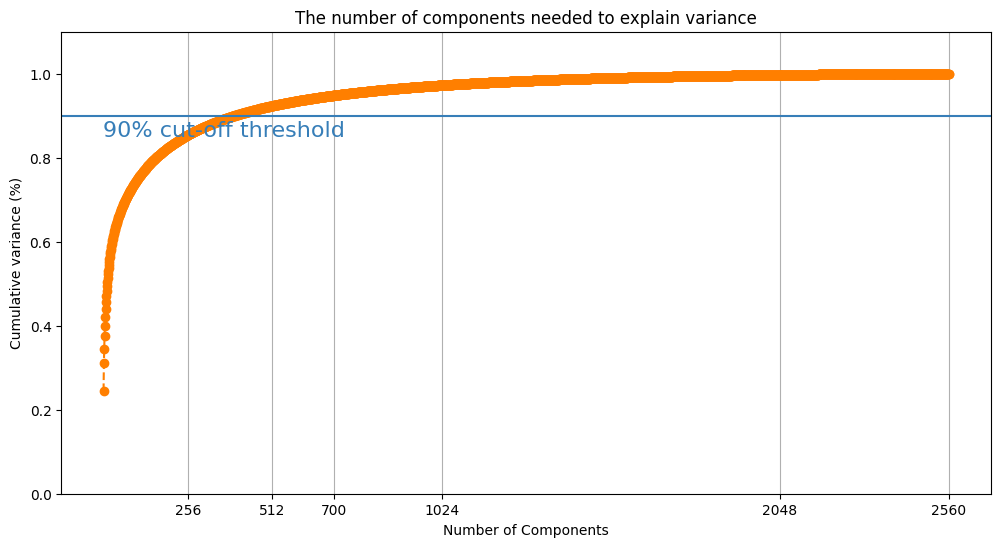

397

In [10]:

pick_n_for_pca(embs_enzymes)

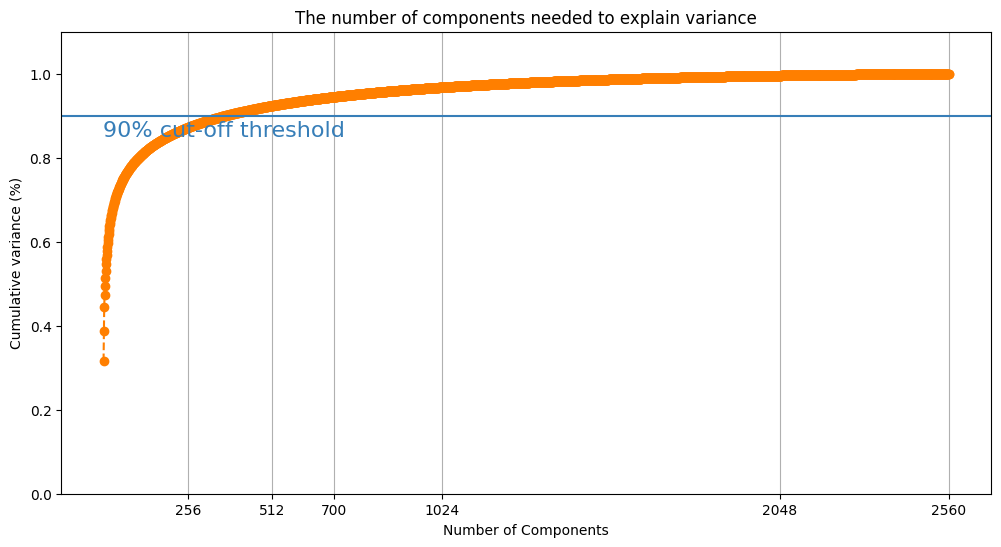

369

In [11]:
pick_n_for_pca(embs_non_enzymes)

Now that with n=700 we get 90% cut off, we choose PCA with 397 dimension

In [12]:
n_dimensions_after_pca=397

<font size="5">Create a dataframe<font>

In [13]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    seqs=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        seqs.append(entry.seq)
        
    emb_pca_all=PCA_for_emb(np.array(embs),n_dimensions_after_pca).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [34]:

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


       Label       Entry        Mass  \
0          1  A0A024RBG1   20403.292   
1          1  A0A024SMV2   42741.490   
2          1  A0A060S684   63631.543   
3          1  A0A075TXZ3   61430.846   
4          1  A0A077K8G3   45202.778   
...      ...         ...         ...   
48701      0      X2JAU8  117164.590   
48702      0      X5HYT8   46670.171   
48703      0      X5LX76  118226.070   
48704      0      X6R8D5   14504.182   
48705      0      X6R8R1   52161.639   

                                                     Emb  Emb median  \
0      [-0.015143169, 0.035552002, -0.02231326, 0.002...   -0.003883   
1      [0.059097216, -0.034141198, 0.061426997, 0.006...   -0.002613   
2      [-0.016934631, -0.04490467, 0.0054878886, -0.0...   -0.002250   
3      [-0.06815035, -0.034723807, 0.03341713, -0.057...   -0.001353   
4      [-0.03639361, 0.046453245, 0.06140146, -0.0697...   -0.004369   
...                                                  ...         ...   
48701  [-0.0968

In [15]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_esm2_df.csv', index = False)

PCA -> df

In [35]:
for i in range(n_dimensions_after_pca):
    df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
df

/tmp/ipykernel_25166/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_25166/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'PCA {i + 1}'] = df['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_25166/1299338572.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,PCA 2,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.7201109528541565, 0.1448671966791153, 0.30...",-0.720111,0.144867,...,-0.006341,-0.008762,-0.028545,0.034667,-0.019314,-0.020970,0.023878,0.008113,-0.018976,-0.012914
1,1,A0A024SMV2,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132580041885376, -0.09059897065162659, -0....",1.113258,-0.090599,...,0.010583,0.055834,0.007874,0.018473,0.015739,0.023396,0.014078,-0.032260,0.034779,0.034282
2,1,A0A060S684,63631.543,"[-0.016934631, -0.04490467, 0.0054878886, -0.0...",-0.002250,0.238975,12.091348,"[-0.14153917133808136, -0.16625410318374634, -...",-0.141539,-0.166254,...,-0.011638,-0.017610,0.040503,0.029687,0.014754,0.030717,-0.035521,-0.045804,-0.014487,0.016783
3,1,A0A075TXZ3,61430.846,"[-0.06815035, -0.034723807, 0.03341713, -0.057...",-0.001353,0.235385,11.909699,"[0.20521414279937744, -0.25431209802627563, -0...",0.205214,-0.254312,...,-0.011318,-0.017933,0.024590,0.031984,0.035870,0.022497,-0.049526,-0.016707,-0.017001,0.043822
4,1,A0A077K8G3,45202.778,"[-0.03639361, 0.046453245, 0.06140146, -0.0697...",-0.004369,0.246203,12.457084,"[-0.11231610178947449, 0.1939609795808792, 0.3...",-0.112316,0.193961,...,0.054126,-0.058284,0.021360,-0.081887,0.026257,-0.058722,0.002962,-0.014668,0.034065,-0.002133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48701,0,X2JAU8,117164.590,"[-0.09689512, -0.090523794, -0.016701577, -0.0...",-0.003210,0.218149,11.037591,"[3.928792715072632, 1.0540295839309692, 0.0701...",3.928793,1.054030,...,0.037625,-0.012486,0.027125,0.070167,-0.028302,0.054892,-0.025628,0.028198,0.037152,0.033864
48702,0,X5HYT8,46670.171,"[0.0023819576, -0.033620838, 0.043625146, -0.0...",-0.003682,0.267518,13.535640,"[-0.8071574568748474, 0.2815750539302826, 0.49...",-0.807157,0.281575,...,-0.009965,-0.000848,0.006757,0.014632,-0.026875,-0.007788,0.025721,-0.048537,0.019030,-0.045022
48703,0,X5LX76,118226.070,"[-0.0035375275, -0.021880746, -0.028436316, 0....",-0.003806,0.255798,12.942582,"[0.03618663549423218, -0.42618653178215027, -0...",0.036187,-0.426187,...,0.027970,-0.006283,0.007746,0.015366,0.043811,0.016580,-0.043133,0.002530,0.022199,0.000393
48704,0,X6R8D5,14504.182,"[-0.009083768, -0.058401734, 0.022719534, -0.0...",-0.004650,0.287314,14.537300,"[-2.6940078735351562, 2.3132102489471436, 0.50...",-2.694008,2.313210,...,0.016764,-0.008630,0.006656,-0.008640,-0.057039,-0.022768,0.046517,0.013621,-0.007574,0.026024


In [23]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30__and_non_enzymes_with_esm2_and_PCA_df.csv', index = False)

Split data into training and validation sets

In [36]:
#Define the features and output:
y = df['Label']
# use 397 PCA components, mass and Emb magnitude as features 
X = df.drop(['Label','Entry','Emb', 'Emb median','Emb std','Emb PCA'],axis=1)
#X = df_with_enzyme_dup[['Mass', 'Emb magnitude']]

#Split data into train an test, with test size of 33%%:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=42)


Duplicate the enzymes class to achieve a balanced dataframe

In [37]:
X_train

,Mass,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
42738,68677.417,12.932137,0.584779,-0.326471,0.070805,0.005982,-0.024381,-0.398042,-0.233990,-0.102004,...,0.009739,-0.035809,0.011392,-0.039667,-0.007567,0.008806,0.035386,-0.019360,-0.040229,0.037126
33829,35941.722,12.755472,0.496581,0.247561,0.325692,-0.059739,-0.101545,-0.328560,-0.749728,0.367323,...,0.037523,0.026590,-0.023554,-0.014065,-0.040555,0.028956,0.016800,0.007422,-0.019353,0.037471
9838,59488.012,11.414863,2.145232,0.067070,-0.669972,-0.412324,0.232452,0.348688,0.163754,-0.257926,...,0.002021,-0.016695,-0.011523,0.029046,-0.013044,-0.021806,0.022670,-0.014355,-0.003227,-0.027348
12019,9521.591,13.174243,-0.160224,-0.434004,-0.770694,0.045688,-0.339791,-0.292376,0.087760,-0.056852,...,0.005532,-0.062845,-0.014208,-0.004788,-0.011241,0.035642,-0.005934,-0.035952,0.030234,-0.058882
47488,184037.944,13.576423,-0.242263,-0.955745,0.423106,0.013659,0.267742,0.472030,-0.014248,-0.113903,...,0.015641,0.021832,0.015454,-0.007803,0.007600,-0.022069,0.028975,-0.005457,-0.013009,0.006172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1207.671,13.874771,0.332583,-0.426883,1.361786,0.263855,0.505994,-0.817764,1.580082,0.579571,...,-0.061989,0.020636,-0.061816,0.030772,-0.037319,-0.002592,0.020389,0.008000,0.004243,0.031423
44732,11011.811,13.258679,0.842327,-0.478655,1.157193,0.159494,0.390672,-0.044824,0.257922,0.031081,...,0.042971,0.002076,-0.019827,-0.024338,-0.028027,-0.001995,0.006131,-0.057886,0.024507,0.006588
38158,65315.096,14.491904,-2.227548,0.590932,0.967998,-0.536130,-0.307147,0.864704,0.091660,-0.637996,...,-0.003765,0.014466,-0.024026,-0.015023,0.007758,-0.002915,0.000701,-0.000545,-0.001733,-0.018091
860,39507.175,11.524400,1.324474,-0.121696,-0.079244,0.418807,0.021615,-0.275153,0.160300,-0.076023,...,-0.011613,0.018159,0.018412,-0.030543,-0.016660,0.003560,0.019746,0.005650,-0.007081,-0.049485


In [46]:
y_train

42738    0
33829    0
9838     0
12019    0
47488    0
        ..
11284    0
44732    0
38158    0
860      1
15795    0
Name: Label, Length: 34094, dtype: int64

In [75]:
train_df = pd.concat([y_train, X_train], axis=1)
mask = train_df['Label'] == 1

# Duplicate rows with label 1 and keep other rows unchanged
train_df_dup = pd.concat([train_df[mask]] * 3, ignore_index=True)

# Concatenate rows with label 1 repeated four times with the original data
train_df_dup = pd.concat([train_df, train_df_dup], ignore_index=True)

# Split the data again into X_train_dup and y_train_dup
train_df_dup = train_df_dup.sort_values(by=['Label','Mass'], ascending=[False, True]).reset_index(drop=True)
y_train_dup = train_df_dup['Label']
X_train_dup = train_df_dup.drop(['Label'], axis=1)


In [76]:
train_df_dup

,Label,Mass,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,1,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
1,1,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
2,1,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
3,1,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
4,1,1807.104,14.096272,-1.676047,-0.885849,-0.280731,0.389827,-1.206275,-0.176408,0.712177,...,-0.003680,-0.081596,0.037470,-0.004772,-0.035045,0.011126,0.016740,0.008123,0.049014,-0.074693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53253,0,801392.933,14.729477,-2.266999,0.220506,-0.010475,0.794912,0.123342,0.215137,-0.425123,...,0.044631,0.035153,0.025252,-0.025216,0.022470,-0.017609,0.004241,0.013163,-0.004558,0.029164
53254,0,893681.916,12.511958,1.004708,-0.503609,0.032783,-0.084079,0.370211,0.463532,-0.274257,...,0.002402,-0.030572,-0.024835,0.024012,0.022293,-0.028543,0.005213,0.002378,0.030808,-0.011409
53255,0,1010437.522,13.602712,-0.411011,-0.607820,0.053133,0.175376,-0.673853,-0.142631,-0.455885,...,-0.046316,0.027656,0.033928,0.022029,0.059714,0.035925,-0.037945,-0.049699,0.082298,-0.022041
53256,0,1050135.477,13.207062,0.529047,-1.051052,-0.102946,0.154646,0.561213,0.472437,0.053868,...,0.036680,0.010413,0.049925,0.007241,0.002086,-0.055274,0.000834,-0.000786,0.001126,-0.031915


In [77]:
y_train_dup

0        1
1        1
2        1
3        1
4        1
        ..
53253    0
53254    0
53255    0
53256    0
53257    0
Name: Label, Length: 53258, dtype: int64

In [78]:
X_train_dup

,Mass,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,0.388682,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
1,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,0.388682,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
2,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,0.388682,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
3,756.395,14.554900,-2.756652,-0.491556,1.920414,-1.074927,0.318987,-0.092931,0.010961,0.388682,...,0.041392,-0.099376,0.159024,0.062715,-0.121493,0.115332,-0.070136,-0.043838,0.005262,0.065538
4,1807.104,14.096272,-1.676047,-0.885849,-0.280731,0.389827,-1.206275,-0.176408,0.712177,0.111976,...,-0.003680,-0.081596,0.037470,-0.004772,-0.035045,0.011126,0.016740,0.008123,0.049014,-0.074693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53253,801392.933,14.729477,-2.266999,0.220506,-0.010475,0.794912,0.123342,0.215137,-0.425123,0.119426,...,0.044631,0.035153,0.025252,-0.025216,0.022470,-0.017609,0.004241,0.013163,-0.004558,0.029164
53254,893681.916,12.511958,1.004708,-0.503609,0.032783,-0.084079,0.370211,0.463532,-0.274257,0.123852,...,0.002402,-0.030572,-0.024835,0.024012,0.022293,-0.028543,0.005213,0.002378,0.030808,-0.011409
53255,1010437.522,13.602712,-0.411011,-0.607820,0.053133,0.175376,-0.673853,-0.142631,-0.455885,0.079446,...,-0.046316,0.027656,0.033928,0.022029,0.059714,0.035925,-0.037945,-0.049699,0.082298,-0.022041
53256,1050135.477,13.207062,0.529047,-1.051052,-0.102946,0.154646,0.561213,0.472437,0.053868,-0.096221,...,0.036680,0.010413,0.049925,0.007241,0.002086,-0.055274,0.000834,-0.000786,0.001126,-0.031915


In [121]:

#Build the model:
rf = RandomForestClassifier(max_depth=16, min_samples_leaf=8,n_estimators=100, random_state=42)


In [ ]:
# Define the performance metrics you want to assess
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
}

# Perform k-fold cross-validation (e.g., 5-fold) and calculate performance metrics
cv_results = {}
n_splits = 5  # Number of splits
for metric_name, scoring_func in scoring_metrics.items():
    scores = cross_val_score(rf, X_train_dup, y_train_dup, cv=n_splits, scoring=scoring_func)
    cv_results[metric_name] = scores

# Calculate mean and standard deviation (standard error) for each metric
for metric_name, scores in cv_results.items():
    mean_score = scores.mean()
    std_score = scores.std()
    print(f'{metric_name}: Mean={mean_score}, Std Dev={std_score}')

In [123]:
rf.fit(X_train_dup, y_train_dup)
y_pred=rf.predict(X_test)

<font size="5">Evaluate the model</font>

In [127]:
# Generate random baseline predictions
n_samples = len(y_test)
random_baseline_predictions = np.random.choice(y_test, n_samples)

# Calculate the accuracy of the random baseline predictions
baseline_accuracy = accuracy_score(y_test, random_baseline_predictions)

print("Baseline Accuracy (Random Guessing):", baseline_accuracy)
print("Model accuracy: %f" % accuracy_score(y_test, y_pred))

Baseline Accuracy (Random Guessing): 0.6917601970982754
Model accuracy: 0.942308


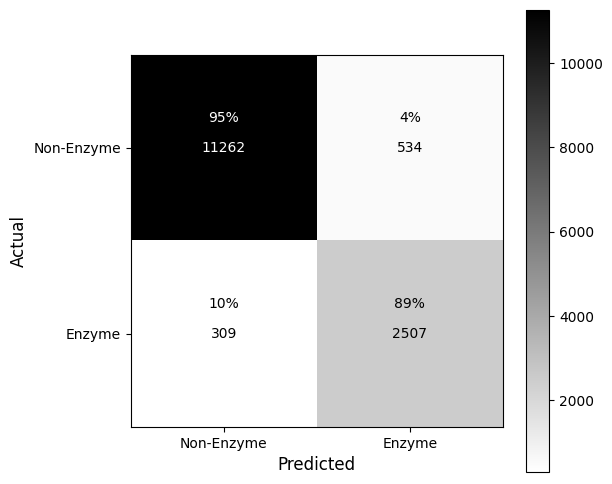

In [125]:
class_names = ["Non-Enzyme", "Enzyme"]
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the percentages
cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap="binary", ax=ax)
cax = ax

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        
        # Increase the vertical offset for the percentage text
        offset = 0.2
        text_color = cax.texts[i * 2 + j].get_color()
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color=text_color, fontsize=10, fontweight='light', zorder=4)
        
        
# Set the x and y labels
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)
ax.grid(False)

plt.show()


In [128]:
f1 = f1_score(y_test, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_test, y_pred)
print('MCC score:', mcc_score)
precision = precision_score(y_test, y_pred)
print(f"Precision = {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall = {recall}")


F1 score: 0.8560696602356155
MCC score: 0.8210071044325231
Precision = 0.8243998684643209
Recall = 0.8902698863636364


<font size="5">Make a tree</font>

In [57]:
rf_3 = RandomForestClassifier(max_depth=3, min_samples_leaf=8,n_estimators=100, random_state=42)
rf_3.fit(X_train_dup, y_train_dup)

tree = rf_3.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file(r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot')
# Write graph to a png file:
graph.write_png(r'/home/trucbui/PBLGit/random_forest/tree_rf_esm2.png')

In [113]:
y_pred_rf3=rf_3.predict(X_test)
f1 = f1_score(y_test, y_pred_rf3, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_test, y_pred_rf3)
print('MCC score:', mcc_score)
precision = precision_score(y_test, y_pred_rf3)
print(f"Precision = {precision}")
recall = recall_score(y_test, y_pred_rf3)
print(f"Recall = {recall}")


F1 score: 0.5963966520073769
MCC score: 0.4919720894588297
Precision = 0.496574533427829
Recall = 0.7464488636363636


<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.9293457527975585


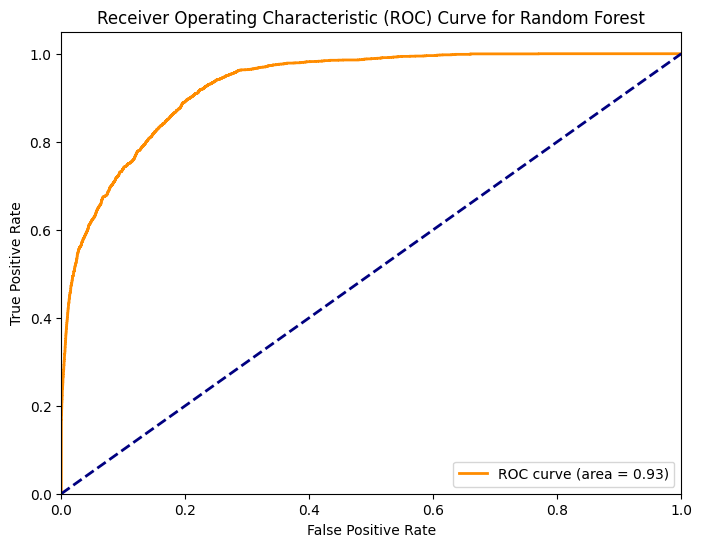

In [59]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

<font size="5">Save the model</font>

In [60]:
# save the model to disk
pickle.dump(rf , open(r'/home/trucbui/PBLGit/random_forest/random_forest_final.pk1' , 'wb'))

# load the model from disk
loaded_model = pickle.load(open(r'/home/trucbui/PBLGit/random_forest/random_forest_final.pk1' , 'rb'))

loaded_model_accuracy = loaded_model.score(X_test, y_test)

print("Loaded Model Accuracy:" , loaded_model_accuracy * 100 , "%")




Loaded Model Accuracy: 82.69915138242541 %
